# **Assignment 05**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels

In [3]:
# mounting google drive to colab
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp 'drive/My Drive/vgg16_ft.pth' './'

In [4]:
# unzipping the dataset
!unzip 'drive/My Drive/Assignment 5 Dataset'

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [9]:
x = os.listdir('Assignment 5 Dataset/test/infected')
print(len(x))

616


### Load Dataset usign torchvision image loader

In [0]:
#Define transforms for the training data and testing data
def loadAndTransformData(path, trainName, testName, validName):
  train_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

  test_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
  
  valid_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

  #pass transform here-in
  train_data = datasets.ImageFolder(path + trainName, transform=train_transforms)
  test_data = datasets.ImageFolder(path + testName, transform=test_transforms)
  valid_data = datasets.ImageFolder(path + validName, transform=valid_transforms)

  #data loaders
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers= 4)
  testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers= 4)
  validloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True, num_workers= 4)
  
  print("Classes: ")
  class_names = train_data.classes
  print(class_names)
  return trainloader, testloader, validloader,class_names

def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  plt.axis('off')
  plt.imshow(inp)
  if title is not None:
      plt.title(title)

def show_databatch(inputs, classes, class_names):
  out = torchvision.utils.make_grid(inputs)
  imshow(out, title=[class_names[x] for x in classes])

def train(model, trainloader, validloader, Epochs, criterion, optimizer, device, modelFileName):
  validAcc = 0
  acc = []
  errors = []
  for epoch in range(Epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      pbar = tqdm(enumerate(trainloader))
      for i, data in pbar:
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
          # because PyTorch accumulates the gradients on subsequent backward passes. 
          # This is convenient while training RNNs. 
          # So, the default action is to accumulate the gradients on every loss.backward() call

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          loss = criterion(outputs, labels)   #----> compute loss
          loss.backward()                     #----> backward pass
          optimizer.step()                    #----> weights update

          # print statistics
          running_loss += loss.item()
          
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item()))
      # validation accuracy
      validAcc = accuracy(model, validloader, device)
      acc.append(validAcc)
      errors.append(running_loss)
      print(f'Validation Accuracy of the epoch: {epoch} on the validation images is {validAcc}')    
      torch.save(model.state_dict(), modelFileName)

  print('Finished Training')
  return errors, acc

def plotStats(errors,acc):
  acc = np.array(acc)
  validErr = 1 - acc    
  plt.plot(errors,'b',label='Train Error')
  plt.plot(validErr,'r', label = 'Validation Error')
  plt.plot(acc, 'g', label = 'Validation Accuracy')
  plt.title('Error and Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Error/Accuracy')
  plt.legend()
  plt.show

def accuracy(model, testloader,device):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  return acc

def confussionM(model, testloader,device):
  pred = []
  corr = []
  values = []
  img = []
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          img.append(images)
          yTrue = labels.numpy()
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          value, predicted = torch.max(outputs.data, 1)
          values = np.append(values, value.cpu().numpy())
          pred = np.append(pred, predicted.cpu().numpy())
          corr = np.append(corr, yTrue)
  
  plot_confusion_matrix(corr, pred, classes=['infected', 'normal'])
  
  x = np.where(pred == corr)
  y = np.where(pred != corr)

  infectedB = np.where(pred[x] == 0)
  infectedW = np.where(pred[y] == 1)
  normalB = np.where(pred[x] == 1)
  normalW = np.where(pred[y] == 0)

  infectedB = values[infectedB]
  infectedW = values[infectedW]
  normalB = values[normalB]
  normalW = values[normalW]

  infectedB = np.sort(infectedB, kind='mergesort')
  infectedW = np.sort(infectedW, kind='mergesort')  
  normalB = np.sort(normalB, kind='mergesort')
  normalW = np.sort(normalW, kind='mergesort')

  bPredI = infectedB[-2:]
  wPredI = infectedW[-2:]
  bPredN = normalB[-2:]
  wPredN = normalW[-2:]
  
  bestI = np.empty(0,dtype=int)
  worstI = np.empty(0,dtype=int)
  bestN = np.empty(0,dtype=int)
  worstN = np.empty(0,dtype=int)

  for i,value in enumerate(values):
    if value == bPredI[0] or value == bPredI[1]:
      bestI = np.append(bestI,i)
    elif value == wPredN[0] or value == wPredN[1]:
      worstN = np.append(worstN,i)
    elif value == wPredI[0] or value == wPredI[1]:
      worstI = np.append(worstI,i)
    elif value == bPredN[0] or value == bPredN[1]:
      bestN = np.append(bestN,i)

  # print(len(bestI))
  # print(len(worstI))
  # print(len(bestN))
  # print(len(worstN))
  bestImgI = []
  worstImgI = []
  bestImgN = []
  worstImgN = []
  for i in range(2):
    if bestI[i] < 128:
      bestImgI.append(img[0][bestI[i]])
    else:
      bestImgI.append(img[int(bestI[i]/128)][int(bestI[i]%128)])
    if worstI[i] < 128:
      worstImgI.append(img[0][worstI[i]])
    else:
      worstImgI.append(img[int(worstI[i]/128)][int(worstI[i]%128)])
    if bestN[i] < 128:
      bestImgN.append(img[0][bestN[i]])
    else:
      bestImgN.append(img[int(bestN[i]/128)][int(bestN[i]%128)])
    if worstN[i] < 128:
      worstImgN.append(img[0][worstN[i]])
    else:
      worstImgN.append(img[int(worstN[i]/128)][int(worstN[i]%128)])
  f1 = f1_score(corr, pred)
  return bestImgI, worstImgI, bestImgN, worstImgN, f1

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
# loading and transforming the dataset
datasetPath = 'Assignment 5 Dataset'
trainloader, testloader, validloader, class_names = loadAndTransformData(datasetPath,'/train','/test','/validation')

Classes: 
['infected', 'normal']


##**Task 01**

## VGG-16

### Load pre-trained VGG-16

In [8]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

### Removing default FC layers and Adding custom FC layers

In [0]:
# my roll number's last two digit are 28
noOfNeurons = (28*10)+100
vgg16.classifier = nn.Sequential(nn.Linear(25088, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [10]:
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[3].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

### Loss fucntion and optimizer

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Training

In [140]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)
vgg16.train()
errors, acc = train(vgg16, trainloader, validloader, Epochs, criterion, optimizer, device,'vgg16_FC_Only.pth')

cuda:0



0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.304963: : 0it [00:08, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.304963: : 1it [00:08,  8.55s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.278683: : 1it [00:08,  8.55s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.278683: : 2it [00:08,  6.11s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.254262: : 2it [00:09,  6.11s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.254262: : 3it [00:09,  4.42s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.310134: : 3it [00:09,  4.42s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.310134: : 4it [00:09,  3.21s/it]
Train Epoch: 0 [512/12000 (4%)]	Loss: 0.322191: : 4it [00:16,  3.21s/it]
Train Epoch: 0 [512/12000 (4%)]	Loss: 0.322191: : 5it [00:16,  4.22s/it]
Train Epoch: 0 [640/12000 (5%)]	Loss: 0.263451: : 5it [00:16,  4.22s/it]
Train Epoch: 0 [640/12000 (5%)]	Loss: 0.263451: : 6it [00:16,  3.06s/it]
Train Epoch: 0 [768/12000 (6%)]	Loss: 0.291225: : 6it [00:17,  3.06s/it]
Train Epoch: 0 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 0 on the validation images is 87.66666666666667



0it [00:00, ?it/s]
Train Epoch: 1 [0/12000 (0%)]	Loss: 0.276025: : 0it [00:08, ?it/s]
Train Epoch: 1 [0/12000 (0%)]	Loss: 0.276025: : 1it [00:08,  8.29s/it]
Train Epoch: 1 [128/12000 (1%)]	Loss: 0.365785: : 1it [00:08,  8.29s/it]
Train Epoch: 1 [128/12000 (1%)]	Loss: 0.365785: : 2it [00:08,  5.92s/it]
Train Epoch: 1 [256/12000 (2%)]	Loss: 0.393213: : 2it [00:09,  5.92s/it]
Train Epoch: 1 [256/12000 (2%)]	Loss: 0.393213: : 3it [00:09,  4.28s/it]
Train Epoch: 1 [384/12000 (3%)]	Loss: 0.264728: : 3it [00:09,  4.28s/it]
Train Epoch: 1 [384/12000 (3%)]	Loss: 0.264728: : 4it [00:09,  3.11s/it]
Train Epoch: 1 [512/12000 (4%)]	Loss: 0.262927: : 4it [00:16,  3.11s/it]
Train Epoch: 1 [512/12000 (4%)]	Loss: 0.262927: : 5it [00:16,  4.22s/it]
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.321527: : 5it [00:16,  4.22s/it]
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.321527: : 6it [00:16,  3.09s/it]
Train Epoch: 1 [768/12000 (6%)]	Loss: 0.270256: : 6it [00:17,  3.09s/it]
Train Epoch: 1 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 1 on the validation images is 87.53333333333333



0it [00:00, ?it/s]
Train Epoch: 2 [0/12000 (0%)]	Loss: 0.364670: : 0it [00:07, ?it/s]
Train Epoch: 2 [0/12000 (0%)]	Loss: 0.364670: : 1it [00:07,  7.94s/it]
Train Epoch: 2 [128/12000 (1%)]	Loss: 0.338351: : 1it [00:08,  7.94s/it]
Train Epoch: 2 [128/12000 (1%)]	Loss: 0.338351: : 2it [00:08,  5.66s/it]
Train Epoch: 2 [256/12000 (2%)]	Loss: 0.258750: : 2it [00:08,  5.66s/it]
Train Epoch: 2 [256/12000 (2%)]	Loss: 0.258750: : 3it [00:08,  4.10s/it]
Train Epoch: 2 [384/12000 (3%)]	Loss: 0.324156: : 3it [00:09,  4.10s/it]
Train Epoch: 2 [384/12000 (3%)]	Loss: 0.324156: : 4it [00:09,  2.98s/it]
Train Epoch: 2 [512/12000 (4%)]	Loss: 0.283547: : 4it [00:15,  2.98s/it]
Train Epoch: 2 [512/12000 (4%)]	Loss: 0.283547: : 5it [00:15,  4.14s/it]
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.347678: : 5it [00:16,  4.14s/it]
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.347678: : 6it [00:16,  3.02s/it]
Train Epoch: 2 [768/12000 (6%)]	Loss: 0.346291: : 6it [00:16,  3.02s/it]
Train Epoch: 2 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 2 on the validation images is 87.8



0it [00:00, ?it/s]
Train Epoch: 3 [0/12000 (0%)]	Loss: 0.273275: : 0it [00:07, ?it/s]
Train Epoch: 3 [0/12000 (0%)]	Loss: 0.273275: : 1it [00:07,  7.75s/it]
Train Epoch: 3 [128/12000 (1%)]	Loss: 0.338645: : 1it [00:08,  7.75s/it]
Train Epoch: 3 [128/12000 (1%)]	Loss: 0.338645: : 2it [00:08,  5.65s/it]
Train Epoch: 3 [256/12000 (2%)]	Loss: 0.288354: : 2it [00:09,  5.65s/it]
Train Epoch: 3 [256/12000 (2%)]	Loss: 0.288354: : 3it [00:09,  4.13s/it]
Train Epoch: 3 [384/12000 (3%)]	Loss: 0.349687: : 3it [00:09,  4.13s/it]
Train Epoch: 3 [384/12000 (3%)]	Loss: 0.349687: : 4it [00:09,  3.00s/it]
Train Epoch: 3 [512/12000 (4%)]	Loss: 0.305811: : 4it [00:15,  3.00s/it]
Train Epoch: 3 [512/12000 (4%)]	Loss: 0.305811: : 5it [00:15,  3.96s/it]
Train Epoch: 3 [640/12000 (5%)]	Loss: 0.261942: : 5it [00:16,  3.96s/it]
Train Epoch: 3 [640/12000 (5%)]	Loss: 0.261942: : 6it [00:16,  2.89s/it]
Train Epoch: 3 [768/12000 (6%)]	Loss: 0.285165: : 6it [00:16,  2.89s/it]
Train Epoch: 3 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 3 on the validation images is 88.33333333333333



0it [00:00, ?it/s]
Train Epoch: 4 [0/12000 (0%)]	Loss: 0.389866: : 0it [00:09, ?it/s]
Train Epoch: 4 [0/12000 (0%)]	Loss: 0.389866: : 1it [00:09,  9.42s/it]
Train Epoch: 4 [128/12000 (1%)]	Loss: 0.303233: : 1it [00:09,  9.42s/it]
Train Epoch: 4 [128/12000 (1%)]	Loss: 0.303233: : 2it [00:09,  6.70s/it]
Train Epoch: 4 [256/12000 (2%)]	Loss: 0.476379: : 2it [00:10,  6.70s/it]
Train Epoch: 4 [256/12000 (2%)]	Loss: 0.476379: : 3it [00:10,  4.83s/it]
Train Epoch: 4 [384/12000 (3%)]	Loss: 0.372294: : 3it [00:10,  4.83s/it]
Train Epoch: 4 [384/12000 (3%)]	Loss: 0.372294: : 4it [00:10,  3.49s/it]
Train Epoch: 4 [512/12000 (4%)]	Loss: 0.220407: : 4it [00:17,  3.49s/it]
Train Epoch: 4 [512/12000 (4%)]	Loss: 0.220407: : 5it [00:17,  4.57s/it]
Train Epoch: 4 [640/12000 (5%)]	Loss: 0.313372: : 5it [00:18,  4.57s/it]
Train Epoch: 4 [640/12000 (5%)]	Loss: 0.313372: : 6it [00:18,  3.31s/it]
Train Epoch: 4 [768/12000 (6%)]	Loss: 0.321499: : 6it [00:18,  3.31s/it]
Train Epoch: 4 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 4 on the validation images is 88.6



0it [00:00, ?it/s]
Train Epoch: 5 [0/12000 (0%)]	Loss: 0.390084: : 0it [00:09, ?it/s]
Train Epoch: 5 [0/12000 (0%)]	Loss: 0.390084: : 1it [00:09,  9.07s/it]
Train Epoch: 5 [128/12000 (1%)]	Loss: 0.356616: : 1it [00:09,  9.07s/it]
Train Epoch: 5 [128/12000 (1%)]	Loss: 0.356616: : 2it [00:09,  6.46s/it]
Train Epoch: 5 [256/12000 (2%)]	Loss: 0.295418: : 2it [00:09,  6.46s/it]
Train Epoch: 5 [256/12000 (2%)]	Loss: 0.295418: : 3it [00:09,  4.66s/it]
Train Epoch: 5 [384/12000 (3%)]	Loss: 0.425703: : 3it [00:10,  4.66s/it]
Train Epoch: 5 [384/12000 (3%)]	Loss: 0.425703: : 4it [00:10,  3.37s/it]
Train Epoch: 5 [512/12000 (4%)]	Loss: 0.244702: : 4it [00:16,  3.37s/it]
Train Epoch: 5 [512/12000 (4%)]	Loss: 0.244702: : 5it [00:16,  4.37s/it]
Train Epoch: 5 [640/12000 (5%)]	Loss: 0.336898: : 5it [00:17,  4.37s/it]
Train Epoch: 5 [640/12000 (5%)]	Loss: 0.336898: : 6it [00:17,  3.17s/it]
Train Epoch: 5 [768/12000 (6%)]	Loss: 0.275862: : 6it [00:17,  3.17s/it]
Train Epoch: 5 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 5 on the validation images is 87.66666666666667



0it [00:00, ?it/s]
Train Epoch: 6 [0/12000 (0%)]	Loss: 0.290455: : 0it [00:07, ?it/s]
Train Epoch: 6 [0/12000 (0%)]	Loss: 0.290455: : 1it [00:07,  7.94s/it]
Train Epoch: 6 [128/12000 (1%)]	Loss: 0.323665: : 1it [00:08,  7.94s/it]
Train Epoch: 6 [128/12000 (1%)]	Loss: 0.323665: : 2it [00:08,  5.67s/it]
Train Epoch: 6 [256/12000 (2%)]	Loss: 0.374363: : 2it [00:08,  5.67s/it]
Train Epoch: 6 [256/12000 (2%)]	Loss: 0.374363: : 3it [00:08,  4.11s/it]
Train Epoch: 6 [384/12000 (3%)]	Loss: 0.252373: : 3it [00:09,  4.11s/it]
Train Epoch: 6 [384/12000 (3%)]	Loss: 0.252373: : 4it [00:09,  2.99s/it]
Train Epoch: 6 [512/12000 (4%)]	Loss: 0.239790: : 4it [00:15,  2.99s/it]
Train Epoch: 6 [512/12000 (4%)]	Loss: 0.239790: : 5it [00:15,  4.04s/it]
Train Epoch: 6 [640/12000 (5%)]	Loss: 0.225946: : 5it [00:15,  4.04s/it]
Train Epoch: 6 [640/12000 (5%)]	Loss: 0.225946: : 6it [00:15,  2.93s/it]
Train Epoch: 6 [768/12000 (6%)]	Loss: 0.336301: : 6it [00:16,  2.93s/it]
Train Epoch: 6 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 6 on the validation images is 89.06666666666666



0it [00:00, ?it/s]
Train Epoch: 7 [0/12000 (0%)]	Loss: 0.333677: : 0it [00:08, ?it/s]
Train Epoch: 7 [0/12000 (0%)]	Loss: 0.333677: : 1it [00:08,  8.14s/it]
Train Epoch: 7 [128/12000 (1%)]	Loss: 0.328269: : 1it [00:08,  8.14s/it]
Train Epoch: 7 [128/12000 (1%)]	Loss: 0.328269: : 2it [00:08,  5.88s/it]
Train Epoch: 7 [256/12000 (2%)]	Loss: 0.290611: : 2it [00:09,  5.88s/it]
Train Epoch: 7 [256/12000 (2%)]	Loss: 0.290611: : 3it [00:09,  4.25s/it]
Train Epoch: 7 [384/12000 (3%)]	Loss: 0.339166: : 3it [00:09,  4.25s/it]
Train Epoch: 7 [384/12000 (3%)]	Loss: 0.339166: : 4it [00:09,  3.09s/it]
Train Epoch: 7 [512/12000 (4%)]	Loss: 0.273762: : 4it [00:16,  3.09s/it]
Train Epoch: 7 [512/12000 (4%)]	Loss: 0.273762: : 5it [00:16,  4.14s/it]
Train Epoch: 7 [640/12000 (5%)]	Loss: 0.296743: : 5it [00:16,  4.14s/it]
Train Epoch: 7 [640/12000 (5%)]	Loss: 0.296743: : 6it [00:16,  3.12s/it]
Train Epoch: 7 [768/12000 (6%)]	Loss: 0.255129: : 6it [00:17,  3.12s/it]
Train Epoch: 7 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 7 on the validation images is 87.66666666666667



0it [00:00, ?it/s]
Train Epoch: 8 [0/12000 (0%)]	Loss: 0.216197: : 0it [00:07, ?it/s]
Train Epoch: 8 [0/12000 (0%)]	Loss: 0.216197: : 1it [00:07,  7.75s/it]
Train Epoch: 8 [128/12000 (1%)]	Loss: 0.274156: : 1it [00:08,  7.75s/it]
Train Epoch: 8 [128/12000 (1%)]	Loss: 0.274156: : 2it [00:08,  5.54s/it]
Train Epoch: 8 [256/12000 (2%)]	Loss: 0.311976: : 2it [00:08,  5.54s/it]
Train Epoch: 8 [256/12000 (2%)]	Loss: 0.311976: : 3it [00:08,  4.13s/it]
Train Epoch: 8 [384/12000 (3%)]	Loss: 0.251824: : 3it [00:09,  4.13s/it]
Train Epoch: 8 [384/12000 (3%)]	Loss: 0.251824: : 4it [00:09,  3.00s/it]
Train Epoch: 8 [512/12000 (4%)]	Loss: 0.300389: : 4it [00:15,  3.00s/it]
Train Epoch: 8 [512/12000 (4%)]	Loss: 0.300389: : 5it [00:15,  4.02s/it]
Train Epoch: 8 [640/12000 (5%)]	Loss: 0.251379: : 5it [00:16,  4.02s/it]
Train Epoch: 8 [640/12000 (5%)]	Loss: 0.251379: : 6it [00:16,  2.92s/it]
Train Epoch: 8 [768/12000 (6%)]	Loss: 0.305723: : 6it [00:16,  2.92s/it]
Train Epoch: 8 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 8 on the validation images is 88.13333333333334



0it [00:00, ?it/s]
Train Epoch: 9 [0/12000 (0%)]	Loss: 0.310926: : 0it [00:07, ?it/s]
Train Epoch: 9 [0/12000 (0%)]	Loss: 0.310926: : 1it [00:07,  7.62s/it]
Train Epoch: 9 [128/12000 (1%)]	Loss: 0.262275: : 1it [00:08,  7.62s/it]
Train Epoch: 9 [128/12000 (1%)]	Loss: 0.262275: : 2it [00:08,  5.51s/it]
Train Epoch: 9 [256/12000 (2%)]	Loss: 0.257470: : 2it [00:08,  5.51s/it]
Train Epoch: 9 [256/12000 (2%)]	Loss: 0.257470: : 3it [00:08,  3.99s/it]
Train Epoch: 9 [384/12000 (3%)]	Loss: 0.344533: : 3it [00:09,  3.99s/it]
Train Epoch: 9 [384/12000 (3%)]	Loss: 0.344533: : 4it [00:09,  2.91s/it]
Train Epoch: 9 [512/12000 (4%)]	Loss: 0.234709: : 4it [00:15,  2.91s/it]
Train Epoch: 9 [512/12000 (4%)]	Loss: 0.234709: : 5it [00:15,  3.90s/it]
Train Epoch: 9 [640/12000 (5%)]	Loss: 0.257423: : 5it [00:15,  3.90s/it]
Train Epoch: 9 [640/12000 (5%)]	Loss: 0.257423: : 6it [00:15,  2.85s/it]
Train Epoch: 9 [768/12000 (6%)]	Loss: 0.353579: : 6it [00:16,  2.85s/it]
Train Epoch: 9 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 9 on the validation images is 87.2
Finished Training


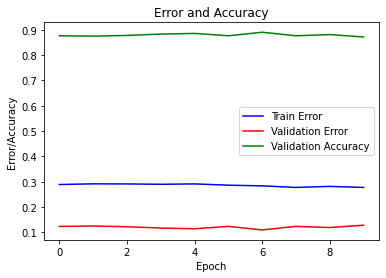

In [145]:
acc = np.array(acc)
errors = np.array(errors)
plotStats(errors/100, acc/100)

### Testing

In [29]:
accuracy(vgg16, testloader, device)

92.66666666666667

Confusion matrix, without normalization
[[515 100]
 [ 10 875]]


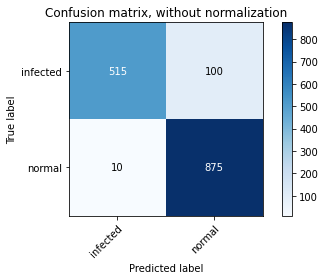

In [64]:
bestI, worstI,  bestN, worstN, f1= confussionM(vgg16, testloader, device)

In [65]:
print('F1 Score:',f1)

F1 Score: 0.9408602150537635


### Best Classified

Infected

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


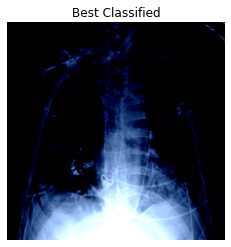

In [66]:
imshow(bestI[0], 'Best Classified')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


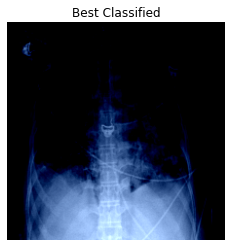

In [67]:
imshow(bestI[1], 'Best Classified')

Normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


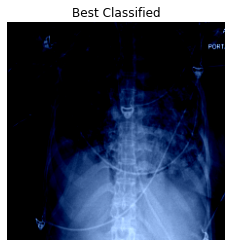

In [68]:
imshow(bestN[0],'Best Classified')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


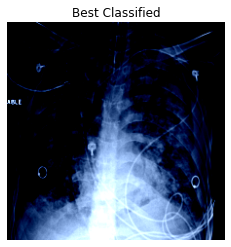

In [69]:
imshow(bestN[1],'Best Classified')

### Worst Classified

Infected

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


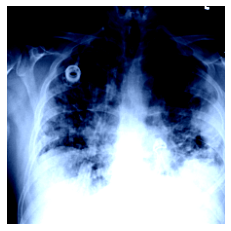

In [70]:
imshow(worstI[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


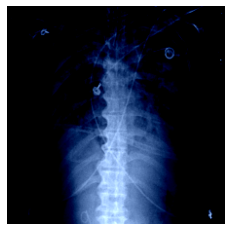

In [71]:
imshow(worstI[1])

Normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


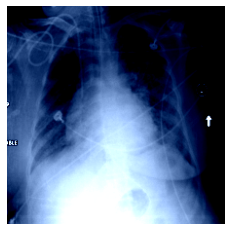

In [72]:
imshow(worstN[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


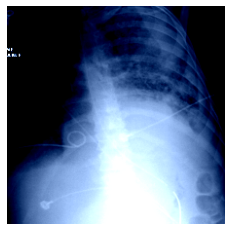

In [73]:
imshow(worstN[1])

## ResNet-18

In [35]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [36]:
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [0]:
noOfNeurons = (28*10)+100
resnet18.fc = nn.Sequential(nn.Linear(512, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [38]:
print(resnet18.fc)

Sequential(
  (0): Linear(in_features=512, out_features=380, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=380, out_features=2, bias=True)
)


In [0]:
for param in resnet18.conv1.parameters():
  param.requires_grad = False
for param in resnet18.bn1.parameters():
  param.requires_grad = False
for param in resnet18.layer1.parameters():
  param.requires_grad = False
for param in resnet18.layer2.parameters():
  param.requires_grad = False
for param in resnet18.layer3.parameters():
  param.requires_grad = False
for param in resnet18.layer4.parameters():
  param.requires_grad = False

In [0]:
rEpochs = 10
rcriterion = nn.CrossEntropyLoss()
roptimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18.to(device)
resnet18.train()
errors, acc = train(resnet18, trainloader, validloader, rEpochs, rcriterion, roptimizer, device,'res18_FC_Only.pth')

cuda:0


Train Epoch: 0 [8928/12000 (99%)]	Loss: 0.498807: : 94it [02:46,  1.77s/it]


Validation Accuracy of the epoch: 0 on the validation images is 76.93333333333334


Train Epoch: 1 [8928/12000 (99%)]	Loss: 0.477322: : 94it [02:41,  1.72s/it]


Validation Accuracy of the epoch: 1 on the validation images is 79.4


Train Epoch: 2 [8928/12000 (99%)]	Loss: 0.464147: : 94it [02:39,  1.70s/it]


Validation Accuracy of the epoch: 2 on the validation images is 79.86666666666666


Train Epoch: 3 [8928/12000 (99%)]	Loss: 0.545723: : 94it [02:42,  1.73s/it]


Validation Accuracy of the epoch: 3 on the validation images is 81.73333333333333


Train Epoch: 4 [8928/12000 (99%)]	Loss: 0.450667: : 94it [02:39,  1.69s/it]


Validation Accuracy of the epoch: 4 on the validation images is 81.73333333333333


Train Epoch: 5 [8928/12000 (99%)]	Loss: 0.291446: : 94it [02:37,  1.68s/it]


Validation Accuracy of the epoch: 5 on the validation images is 82.4


Train Epoch: 6 [8928/12000 (99%)]	Loss: 0.482418: : 94it [02:37,  1.68s/it]


Validation Accuracy of the epoch: 6 on the validation images is 81.8


Train Epoch: 7 [8928/12000 (99%)]	Loss: 0.436399: : 94it [02:37,  1.68s/it]


Validation Accuracy of the epoch: 7 on the validation images is 83.46666666666667


Train Epoch: 8 [8928/12000 (99%)]	Loss: 0.431497: : 94it [02:37,  1.68s/it]


Validation Accuracy of the epoch: 8 on the validation images is 82.93333333333334


Train Epoch: 9 [8928/12000 (99%)]	Loss: 0.330899: : 94it [02:36,  1.67s/it]


Validation Accuracy of the epoch: 9 on the validation images is 83.2
Finished Training


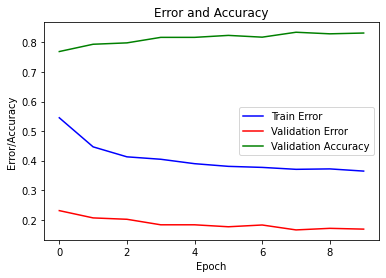

In [0]:
acc = np.array(acc)
errors = np.array(errors)
plotStats(errors/100, acc/100)

In [43]:
accuracy(resnet18, testloader, device)

91.33333333333333

Confusion matrix, without normalization
[[554  61]
 [ 69 816]]


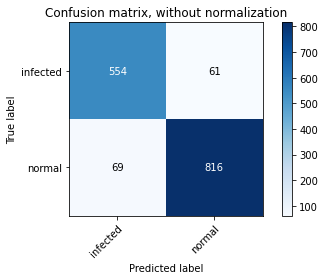

In [74]:
rbestI, rworstI,  rbestN, rworstN, rf1= confussionM(resnet18, testloader, device)

In [83]:
print('F1 score: ', rf1)

F1 score:  0.9262202043132803


### Best Classified Images

Infected

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


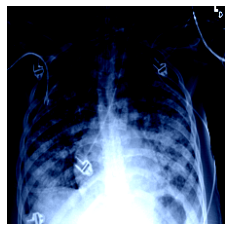

In [75]:
imshow(rbestI[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


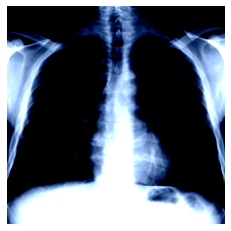

In [76]:
imshow(rbestI[1])

Normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


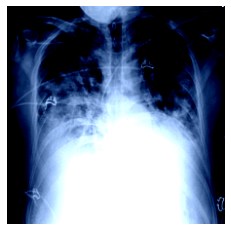

In [77]:
imshow(rbestN[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


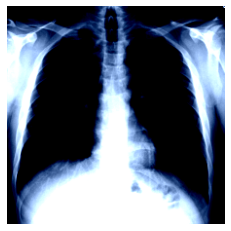

In [78]:
imshow(rbestN[1])

### Worst Classified Images

Infected

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


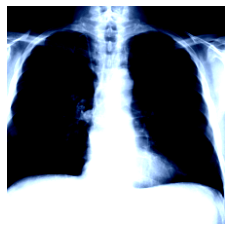

In [79]:
imshow(rworstI[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


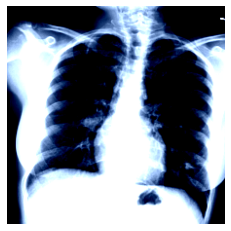

In [80]:
imshow(rworstI[1])

Normal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


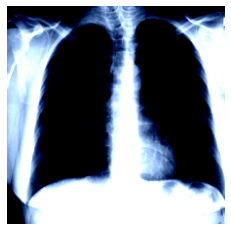

In [81]:
imshow(rworstN[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


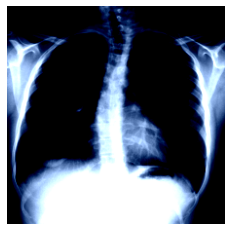

In [82]:
imshow(rworstN[1])

## **Task 02**

### VGG-16 Entire

In [84]:
# Load the pretrained model from pytorch
vgg16_02 = models.vgg16(pretrained=True)
print(vgg16_02)
print('Output Layer of VGG16 : ', vgg16_02.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# my roll number's last two digit are 28
noOfNeurons = (28*10)+100
vgg16_02.classifier = nn.Sequential(nn.Linear(25088, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [86]:
print(vgg16_02)
print('Output Layer of VGG16 : ', vgg16_02.classifier[3].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs2 = 10
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(vgg16_02.parameters(), lr=0.001, momentum=0.9)

In [153]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
print(device)
vgg16_02.to(device)
vgg16_02.train()
errors2, acc2 = train(vgg16_02, trainloader, validloader, Epochs2, criterion2, optimizer2, device,'vgg16_entire.pth')

cuda:0



0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.695082: : 0it [00:09, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.695082: : 1it [00:09,  9.72s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.697892: : 1it [00:10,  9.72s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.697892: : 2it [00:10,  7.10s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.657531: : 2it [00:11,  7.10s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.657531: : 3it [00:11,  5.29s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.664623: : 3it [00:12,  5.29s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.664623: : 4it [00:12,  4.00s/it]
Train Epoch: 0 [512/12000 (4%)]	Loss: 0.690283: : 4it [00:17,  4.00s/it]
Train Epoch: 0 [512/12000 (4%)]	Loss: 0.690283: : 5it [00:17,  4.35s/it]
Train Epoch: 0 [640/12000 (5%)]	Loss: 0.676566: : 5it [00:18,  4.35s/it]
Train Epoch: 0 [640/12000 (5%)]	Loss: 0.676566: : 6it [00:18,  3.34s/it]
Train Epoch: 0 [768/12000 (6%)]	Loss: 0.656012: : 6it [00:19,  3.34s/it]
Train Epoch: 0 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 0 on the validation images is 87.93333333333334



0it [00:00, ?it/s]
Train Epoch: 1 [0/12000 (0%)]	Loss: 0.336417: : 0it [00:08, ?it/s]
Train Epoch: 1 [0/12000 (0%)]	Loss: 0.336417: : 1it [00:08,  8.04s/it]
Train Epoch: 1 [128/12000 (1%)]	Loss: 0.364357: : 1it [00:09,  8.04s/it]
Train Epoch: 1 [128/12000 (1%)]	Loss: 0.364357: : 2it [00:09,  5.93s/it]
Train Epoch: 1 [256/12000 (2%)]	Loss: 0.259840: : 2it [00:10,  5.93s/it]
Train Epoch: 1 [256/12000 (2%)]	Loss: 0.259840: : 3it [00:10,  4.46s/it]
Train Epoch: 1 [384/12000 (3%)]	Loss: 0.247237: : 3it [00:11,  4.46s/it]
Train Epoch: 1 [384/12000 (3%)]	Loss: 0.247237: : 4it [00:11,  3.42s/it]
Train Epoch: 1 [512/12000 (4%)]	Loss: 0.271569: : 4it [00:16,  3.42s/it]
Train Epoch: 1 [512/12000 (4%)]	Loss: 0.271569: : 5it [00:16,  4.02s/it]
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.417425: : 5it [00:17,  4.02s/it]
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.417425: : 6it [00:17,  3.12s/it]
Train Epoch: 1 [768/12000 (6%)]	Loss: 0.394000: : 6it [00:18,  3.12s/it]
Train Epoch: 1 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 1 on the validation images is 90.26666666666667



0it [00:00, ?it/s]
Train Epoch: 2 [0/12000 (0%)]	Loss: 0.373055: : 0it [00:08, ?it/s]
Train Epoch: 2 [0/12000 (0%)]	Loss: 0.373055: : 1it [00:08,  8.39s/it]
Train Epoch: 2 [128/12000 (1%)]	Loss: 0.231126: : 1it [00:09,  8.39s/it]
Train Epoch: 2 [128/12000 (1%)]	Loss: 0.231126: : 2it [00:09,  6.17s/it]
Train Epoch: 2 [256/12000 (2%)]	Loss: 0.361257: : 2it [00:10,  6.17s/it]
Train Epoch: 2 [256/12000 (2%)]	Loss: 0.361257: : 3it [00:10,  4.64s/it]
Train Epoch: 2 [384/12000 (3%)]	Loss: 0.297887: : 3it [00:11,  4.64s/it]
Train Epoch: 2 [384/12000 (3%)]	Loss: 0.297887: : 4it [00:11,  3.56s/it]
Train Epoch: 2 [512/12000 (4%)]	Loss: 0.292321: : 4it [00:16,  3.56s/it]
Train Epoch: 2 [512/12000 (4%)]	Loss: 0.292321: : 5it [00:16,  3.98s/it]
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.360030: : 5it [00:17,  3.98s/it]
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.360030: : 6it [00:17,  3.09s/it]
Train Epoch: 2 [768/12000 (6%)]	Loss: 0.233062: : 6it [00:18,  3.09s/it]
Train Epoch: 2 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 2 on the validation images is 90.66666666666667



0it [00:00, ?it/s]
Train Epoch: 3 [0/12000 (0%)]	Loss: 0.348088: : 0it [00:08, ?it/s]
Train Epoch: 3 [0/12000 (0%)]	Loss: 0.348088: : 1it [00:08,  8.36s/it]
Train Epoch: 3 [128/12000 (1%)]	Loss: 0.299937: : 1it [00:09,  8.36s/it]
Train Epoch: 3 [128/12000 (1%)]	Loss: 0.299937: : 2it [00:09,  6.16s/it]
Train Epoch: 3 [256/12000 (2%)]	Loss: 0.336676: : 2it [00:10,  6.16s/it]
Train Epoch: 3 [256/12000 (2%)]	Loss: 0.336676: : 3it [00:10,  4.65s/it]
Train Epoch: 3 [384/12000 (3%)]	Loss: 0.239307: : 3it [00:11,  4.65s/it]
Train Epoch: 3 [384/12000 (3%)]	Loss: 0.239307: : 4it [00:11,  3.56s/it]
Train Epoch: 3 [512/12000 (4%)]	Loss: 0.232894: : 4it [00:16,  3.56s/it]
Train Epoch: 3 [512/12000 (4%)]	Loss: 0.232894: : 5it [00:16,  4.05s/it]
Train Epoch: 3 [640/12000 (5%)]	Loss: 0.236405: : 5it [00:17,  4.05s/it]
Train Epoch: 3 [640/12000 (5%)]	Loss: 0.236405: : 6it [00:17,  3.14s/it]
Train Epoch: 3 [768/12000 (6%)]	Loss: 0.224980: : 6it [00:18,  3.14s/it]
Train Epoch: 3 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 3 on the validation images is 90.2



0it [00:00, ?it/s]
Train Epoch: 4 [0/12000 (0%)]	Loss: 0.217415: : 0it [00:08, ?it/s]
Train Epoch: 4 [0/12000 (0%)]	Loss: 0.217415: : 1it [00:08,  8.46s/it]
Train Epoch: 4 [128/12000 (1%)]	Loss: 0.301916: : 1it [00:09,  8.46s/it]
Train Epoch: 4 [128/12000 (1%)]	Loss: 0.301916: : 2it [00:09,  6.22s/it]
Train Epoch: 4 [256/12000 (2%)]	Loss: 0.210638: : 2it [00:10,  6.22s/it]
Train Epoch: 4 [256/12000 (2%)]	Loss: 0.210638: : 3it [00:10,  4.69s/it]
Train Epoch: 4 [384/12000 (3%)]	Loss: 0.247517: : 3it [00:11,  4.69s/it]
Train Epoch: 4 [384/12000 (3%)]	Loss: 0.247517: : 4it [00:11,  3.58s/it]
Train Epoch: 4 [512/12000 (4%)]	Loss: 0.185942: : 4it [00:17,  3.58s/it]
Train Epoch: 4 [512/12000 (4%)]	Loss: 0.185942: : 5it [00:17,  4.15s/it]
Train Epoch: 4 [640/12000 (5%)]	Loss: 0.307097: : 5it [00:18,  4.15s/it]
Train Epoch: 4 [640/12000 (5%)]	Loss: 0.307097: : 6it [00:18,  3.21s/it]
Train Epoch: 4 [768/12000 (6%)]	Loss: 0.219841: : 6it [00:19,  3.21s/it]
Train Epoch: 4 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 4 on the validation images is 91.33333333333333



0it [00:00, ?it/s]
Train Epoch: 5 [0/12000 (0%)]	Loss: 0.255284: : 0it [00:08, ?it/s]
Train Epoch: 5 [0/12000 (0%)]	Loss: 0.255284: : 1it [00:08,  8.51s/it]
Train Epoch: 5 [128/12000 (1%)]	Loss: 0.246169: : 1it [00:09,  8.51s/it]
Train Epoch: 5 [128/12000 (1%)]	Loss: 0.246169: : 2it [00:09,  6.26s/it]
Train Epoch: 5 [256/12000 (2%)]	Loss: 0.295416: : 2it [00:10,  6.26s/it]
Train Epoch: 5 [256/12000 (2%)]	Loss: 0.295416: : 3it [00:10,  4.71s/it]
Train Epoch: 5 [384/12000 (3%)]	Loss: 0.280522: : 3it [00:11,  4.71s/it]
Train Epoch: 5 [384/12000 (3%)]	Loss: 0.280522: : 4it [00:11,  3.60s/it]
Train Epoch: 5 [512/12000 (4%)]	Loss: 0.307092: : 4it [00:16,  3.60s/it]
Train Epoch: 5 [512/12000 (4%)]	Loss: 0.307092: : 5it [00:16,  4.10s/it]
Train Epoch: 5 [640/12000 (5%)]	Loss: 0.226686: : 5it [00:17,  4.10s/it]
Train Epoch: 5 [640/12000 (5%)]	Loss: 0.226686: : 6it [00:17,  3.17s/it]
Train Epoch: 5 [768/12000 (6%)]	Loss: 0.279142: : 6it [00:18,  3.17s/it]
Train Epoch: 5 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 5 on the validation images is 89.66666666666667



0it [00:00, ?it/s]
Train Epoch: 6 [0/12000 (0%)]	Loss: 0.286690: : 0it [00:08, ?it/s]
Train Epoch: 6 [0/12000 (0%)]	Loss: 0.286690: : 1it [00:08,  8.63s/it]
Train Epoch: 6 [128/12000 (1%)]	Loss: 0.316400: : 1it [00:09,  8.63s/it]
Train Epoch: 6 [128/12000 (1%)]	Loss: 0.316400: : 2it [00:09,  6.35s/it]
Train Epoch: 6 [256/12000 (2%)]	Loss: 0.304949: : 2it [00:10,  6.35s/it]
Train Epoch: 6 [256/12000 (2%)]	Loss: 0.304949: : 3it [00:10,  4.77s/it]
Train Epoch: 6 [384/12000 (3%)]	Loss: 0.214765: : 3it [00:11,  4.77s/it]
Train Epoch: 6 [384/12000 (3%)]	Loss: 0.214765: : 4it [00:11,  3.64s/it]
Train Epoch: 6 [512/12000 (4%)]	Loss: 0.214560: : 4it [00:16,  3.64s/it]
Train Epoch: 6 [512/12000 (4%)]	Loss: 0.214560: : 5it [00:16,  3.98s/it]
Train Epoch: 6 [640/12000 (5%)]	Loss: 0.216036: : 5it [00:17,  3.98s/it]
Train Epoch: 6 [640/12000 (5%)]	Loss: 0.216036: : 6it [00:17,  3.10s/it]
Train Epoch: 6 [768/12000 (6%)]	Loss: 0.289833: : 6it [00:18,  3.10s/it]
Train Epoch: 6 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 6 on the validation images is 91.0



0it [00:00, ?it/s]
Train Epoch: 7 [0/12000 (0%)]	Loss: 0.247258: : 0it [00:07, ?it/s]
Train Epoch: 7 [0/12000 (0%)]	Loss: 0.247258: : 1it [00:07,  7.99s/it]
Train Epoch: 7 [128/12000 (1%)]	Loss: 0.158600: : 1it [00:08,  7.99s/it]
Train Epoch: 7 [128/12000 (1%)]	Loss: 0.158600: : 2it [00:09,  5.90s/it]
Train Epoch: 7 [256/12000 (2%)]	Loss: 0.142015: : 2it [00:10,  5.90s/it]
Train Epoch: 7 [256/12000 (2%)]	Loss: 0.142015: : 3it [00:10,  4.45s/it]
Train Epoch: 7 [384/12000 (3%)]	Loss: 0.158138: : 3it [00:11,  4.45s/it]
Train Epoch: 7 [384/12000 (3%)]	Loss: 0.158138: : 4it [00:11,  3.42s/it]
Train Epoch: 7 [512/12000 (4%)]	Loss: 0.230700: : 4it [00:15,  3.42s/it]
Train Epoch: 7 [512/12000 (4%)]	Loss: 0.230700: : 5it [00:15,  3.79s/it]
Train Epoch: 7 [640/12000 (5%)]	Loss: 0.257752: : 5it [00:16,  3.79s/it]
Train Epoch: 7 [640/12000 (5%)]	Loss: 0.257752: : 6it [00:16,  2.96s/it]
Train Epoch: 7 [768/12000 (6%)]	Loss: 0.245729: : 6it [00:17,  2.96s/it]
Train Epoch: 7 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 7 on the validation images is 91.2



0it [00:00, ?it/s]
Train Epoch: 8 [0/12000 (0%)]	Loss: 0.291878: : 0it [00:08, ?it/s]
Train Epoch: 8 [0/12000 (0%)]	Loss: 0.291878: : 1it [00:08,  8.83s/it]
Train Epoch: 8 [128/12000 (1%)]	Loss: 0.242074: : 1it [00:09,  8.83s/it]
Train Epoch: 8 [128/12000 (1%)]	Loss: 0.242074: : 2it [00:09,  6.48s/it]
Train Epoch: 8 [256/12000 (2%)]	Loss: 0.231994: : 2it [00:10,  6.48s/it]
Train Epoch: 8 [256/12000 (2%)]	Loss: 0.231994: : 3it [00:10,  4.87s/it]
Train Epoch: 8 [384/12000 (3%)]	Loss: 0.243353: : 3it [00:11,  4.87s/it]
Train Epoch: 8 [384/12000 (3%)]	Loss: 0.243353: : 4it [00:11,  3.71s/it]
Train Epoch: 8 [512/12000 (4%)]	Loss: 0.303362: : 4it [00:16,  3.71s/it]
Train Epoch: 8 [512/12000 (4%)]	Loss: 0.303362: : 5it [00:16,  4.04s/it]
Train Epoch: 8 [640/12000 (5%)]	Loss: 0.190247: : 5it [00:17,  4.04s/it]
Train Epoch: 8 [640/12000 (5%)]	Loss: 0.190247: : 6it [00:17,  3.13s/it]
Train Epoch: 8 [768/12000 (6%)]	Loss: 0.200319: : 6it [00:18,  3.13s/it]
Train Epoch: 8 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 8 on the validation images is 91.46666666666667



0it [00:00, ?it/s]
Train Epoch: 9 [0/12000 (0%)]	Loss: 0.173075: : 0it [00:08, ?it/s]
Train Epoch: 9 [0/12000 (0%)]	Loss: 0.173075: : 1it [00:08,  8.69s/it]
Train Epoch: 9 [128/12000 (1%)]	Loss: 0.246453: : 1it [00:09,  8.69s/it]
Train Epoch: 9 [128/12000 (1%)]	Loss: 0.246453: : 2it [00:09,  6.40s/it]
Train Epoch: 9 [256/12000 (2%)]	Loss: 0.194539: : 2it [00:10,  6.40s/it]
Train Epoch: 9 [256/12000 (2%)]	Loss: 0.194539: : 3it [00:10,  4.81s/it]
Train Epoch: 9 [384/12000 (3%)]	Loss: 0.247678: : 3it [00:11,  4.81s/it]
Train Epoch: 9 [384/12000 (3%)]	Loss: 0.247678: : 4it [00:11,  3.68s/it]
Train Epoch: 9 [512/12000 (4%)]	Loss: 0.166770: : 4it [00:17,  3.68s/it]
Train Epoch: 9 [512/12000 (4%)]	Loss: 0.166770: : 5it [00:17,  4.16s/it]
Train Epoch: 9 [640/12000 (5%)]	Loss: 0.167006: : 5it [00:18,  4.16s/it]
Train Epoch: 9 [640/12000 (5%)]	Loss: 0.167006: : 6it [00:18,  3.23s/it]
Train Epoch: 9 [768/12000 (6%)]	Loss: 0.136398: : 6it [00:19,  3.23s/it]
Train Epoch: 9 [768/12000 (6%)]	Loss: 0

Validation Accuracy of the epoch: 9 on the validation images is 90.53333333333333
Finished Training


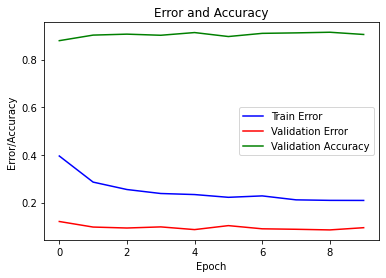

In [188]:
acc2 = np.array(acc2)
errors2 = np.array(errors2)
plotStats(errors2/100, acc2/100)

In [89]:
vgg16_02.to(device)
vgg16_02.load_state_dict(torch.load('drive/My Drive/vgg16_entire.pth'))
vgg16_02.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [92]:
accuracy(vgg16_02,testloader,device)

95.53333333333333

Confusion matrix, without normalization
[[550  65]
 [  2 883]]


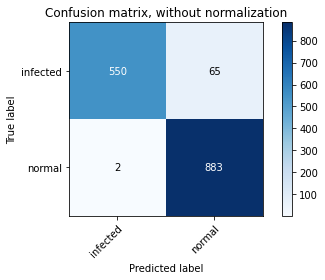

In [91]:
best2I, worst2I, best2N, worst2N, f1_2 = confussionM(vgg16_02, testloader, device)

In [94]:
print('F1 Score',f1_2)

F1 Score 0.9634478996181124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


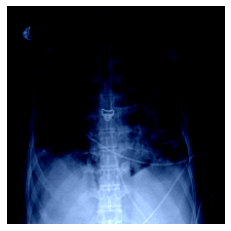

In [95]:
imshow(best2I[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


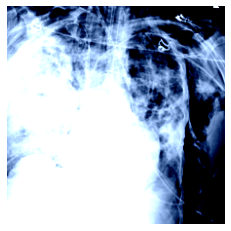

In [96]:
imshow(best2I[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


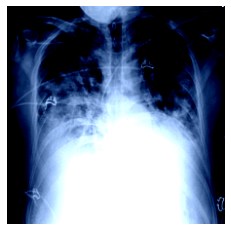

In [97]:
imshow(best2N[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


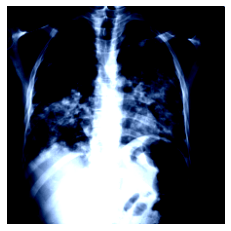

In [98]:
imshow(best2N[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


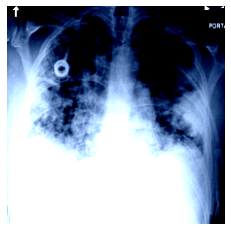

In [99]:
imshow(worst2I[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


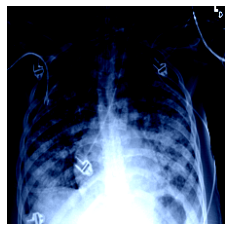

In [100]:
imshow(worst2I[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


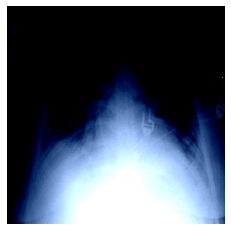

In [101]:
imshow(worst2N[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


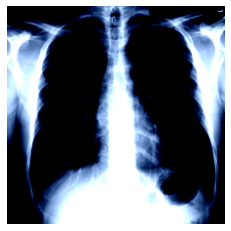

In [102]:
imshow(worst2N[1])

### ResNet-18 Entire

In [103]:
resnet18_02 = models.resnet18(pretrained=True)
print(resnet18_02)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
noOfNeurons = (28*10)+100
resnet18_02.fc = nn.Sequential(nn.Linear(512, noOfNeurons),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(noOfNeurons, len(class_names))
)

In [105]:
print(resnet18_02.fc)

Sequential(
  (0): Linear(in_features=512, out_features=380, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=380, out_features=2, bias=True)
)


In [0]:
rEpochs2 = 10
rcriterion2 = nn.CrossEntropyLoss()
roptimizer2 = optim.SGD(resnet18_02.parameters(), lr=0.001, momentum=0.9)

In [0]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
print(device)
resnet18_02.to(device)
resnet18_02.train()
errors2, acc2 = train(resnet18_02, trainloader, validloader, rEpochs2, rcriterion2, roptimizer2, device,'res18_entire.pth')

cuda:0


Train Epoch: 0 [8928/12000 (99%)]	Loss: 0.536885: : 94it [02:59,  1.91s/it]


Validation Accuracy of the epoch: 0 on the validation images is 84.93333333333334


Train Epoch: 1 [8928/12000 (99%)]	Loss: 0.310951: : 94it [02:46,  1.77s/it]


Validation Accuracy of the epoch: 1 on the validation images is 85.8


Train Epoch: 2 [8928/12000 (99%)]	Loss: 0.305568: : 94it [02:42,  1.73s/it]


Validation Accuracy of the epoch: 2 on the validation images is 88.13333333333334


Train Epoch: 3 [8928/12000 (99%)]	Loss: 0.236525: : 94it [02:41,  1.71s/it]


Validation Accuracy of the epoch: 3 on the validation images is 87.66666666666667


Train Epoch: 4 [8928/12000 (99%)]	Loss: 0.427532: : 94it [02:41,  1.72s/it]


Validation Accuracy of the epoch: 4 on the validation images is 89.66666666666667


Train Epoch: 5 [8928/12000 (99%)]	Loss: 0.197384: : 94it [02:40,  1.71s/it]


Validation Accuracy of the epoch: 5 on the validation images is 89.6


Train Epoch: 6 [8928/12000 (99%)]	Loss: 0.210682: : 94it [02:41,  1.72s/it]


Validation Accuracy of the epoch: 6 on the validation images is 89.53333333333333


Train Epoch: 7 [8928/12000 (99%)]	Loss: 0.214222: : 94it [02:40,  1.71s/it]


Validation Accuracy of the epoch: 7 on the validation images is 89.8


Train Epoch: 8 [8928/12000 (99%)]	Loss: 0.216522: : 94it [02:40,  1.71s/it]


Validation Accuracy of the epoch: 8 on the validation images is 90.53333333333333


Train Epoch: 9 [8928/12000 (99%)]	Loss: 0.357721: : 94it [02:40,  1.71s/it]


Validation Accuracy of the epoch: 9 on the validation images is 90.2
Finished Training


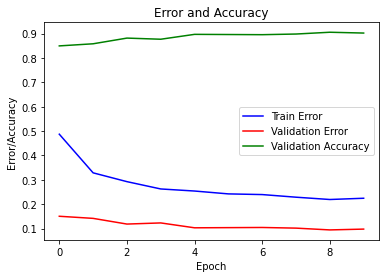

In [0]:
errors2 = np.array(errors2)
acc2 = np.array(acc2)
plotStats(errors2/100,acc2/100)

In [109]:
resnet18_02.to(device)
resnet18_02.load_state_dict(torch.load('drive/My Drive/res18_entire.pth'))
resnet18_02.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [110]:
accuracy(resnet18_02, testloader, device)

96.13333333333334

Confusion matrix, without normalization
[[579  36]
 [ 22 863]]


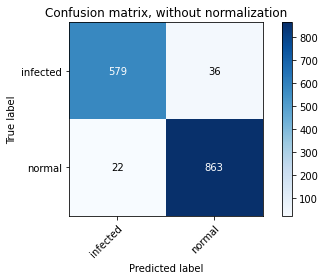

In [111]:
rbestI2, rworstI2, rbestN2, rworstN2, rf1_2 = confussionM(resnet18_02, testloader, device)

In [112]:
print('F1 Score',rf1_2)

F1 Score 0.9674887892376681


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


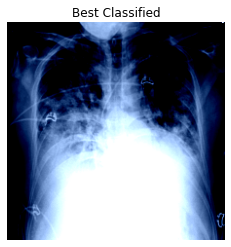

In [113]:
imshow(rbestI2[0], 'Best Classified')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


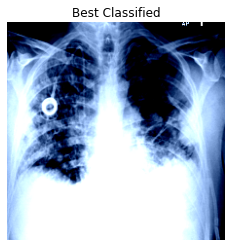

In [114]:
imshow(rbestI2[1], 'Best Classified')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


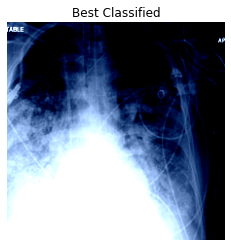

In [115]:
imshow(rbestN2[0],'Best Classified')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


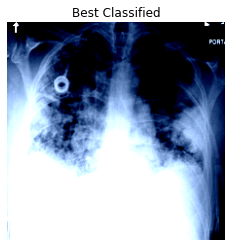

In [116]:
imshow(rbestN2[1],'Best Classified')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


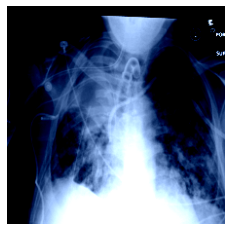

In [117]:
imshow(rworstI2[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


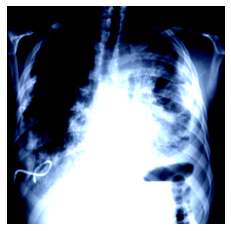

In [118]:
imshow(rworstI2[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


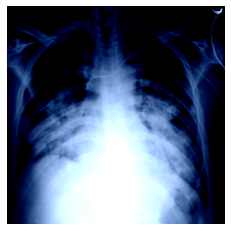

In [119]:
imshow(rworstN2[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


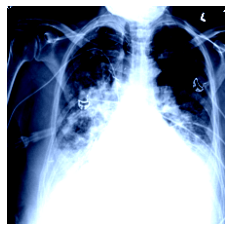

In [120]:
imshow(rworstN2[1])